In [5]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#!/usr/bin/python	
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from obspy.segy.segy import readSEGY
from obspy.core.utcdatetime import UTCDateTime
% matplotlib inline

In [9]:
ls

Alaska/
Burning the ground Alaska.ipynb
Where_is_the_ground_at.png
full_section_earth_surface_included.png
ground_level_depth_structure.png
ground_level_time_structure.png
here_da_ground_at.png
seabed_penobscot.png
where_da_ground_at.png
where_da_ground_at.svg
where_is_ground.png
where_is_ground_zoom.png


data come from here:
    
    http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx

In [10]:
datadir = 'Alaska/'
segyfile = '36_77_PR.sgy'

filename = datadir + segyfile
print ("SEGY File: " + filename)

SEGY File: Alaska/36_77_PR.sgy


In [35]:
def text_header_lines(header):
    """
    Takes SEGY textual header and turns it into a list of strings
    Where each string is one line (80 Characters long)
    This just prints nicely
    """
    header_list = []
    for i in range(80):
        header_list.append(header[80*(i-1):80*i])
    return header_list

In [38]:
section = readSEGY(filename,unpack_headers=True)
text_header_lines(section.textual_file_header)[0:41]  # this prints nicer

[b'',
 b'C 1                                                                             ',
 b'C 2     \x00 Q \x00  \x00\x00 V \x00                                                           ',
 b'C 3         660321SY                                                            ',
 b'C 4                                                                             ',
 b'C 5                                                                             ',
 b'C 6                                                                             ',
 b'C 7                                                                             ',
 b'C 8                                                                             ',
 b'C 9                                                                             ',
 b'C10                                                                             ',
 b'C11                                                                             ',
 b'C12                           

Oh dear, there's no useful information in the textual file header. Let's probe into some attributes of the trace headers and see if there is any information we can extract.

## Let's look at some values we might need from the trace headers

In [50]:
ntraces = len(section.traces)
print (ntraces)

1560


In [51]:
# Choose a number between 1 and len(section.traces)
n = 99  
tr = section.traces[n] # the 100 th trace in the file

In [52]:
print ('TRACE:', n)
print('  > CMP:', tr.header.ensemble_number)
print('  > X:', tr.header.group_coordinate_x)
print('  > Y:', tr.header.group_coordinate_y)
print('  > datum (rec):', tr.header.datum_elevation_at_receiver_group)
print('  > datum (source):', tr.header.datum_elevation_at_source)
print('  > static (ms):', tr.header.group_static_correction_in_ms)
print('  > r_elev:', tr.header.receiver_group_elevation)
print('  > s_elev:', tr.header.surface_elevation_at_source)
print('  > sbs_elev:', tr.header.source_depth_below_surface)
print('  > sub_weath_vel:', tr.header.subweathering_velocity)

TRACE: 99
  > CMP: 248
  > X: 0
  > Y: 0
  > datum (rec): 0
  > datum (source): 0
  > static (ms): 0
  > r_elev: 0
  > s_elev: 0
  > sbs_elev: 0
  > sub_weath_vel: 0


Oh dear, there doesn't seem to be any useful information in the trace headers either. Who made this file?! 

# Get Geoms
Unfortunately, the coordinates (x,y,z) for the top of each trace is missing in this particular SEGY file, so we have to get that information from somewhere else. 

In a pinch, we can . If we were really proactive, we could write the missing information back into correct trace header byte locations for safekeeping. But I'll save that for another exercise.



In [53]:
xx1, yy1 = -1857719, 2870365  # coordinates of start of line
xx2, yy2 = -1836349, 2914314  # coordinates of end of line
 
dx = (xx2-xx1)
dy = (yy2-yy1)

dz = (dx**2.0 + dy**2.0)**0.5

print('length of line is ~', int(dz/1000), 'km')

length of line is ~ 48 km


In [21]:
SP_elev_file = 'Alaska/36-77_CMP_elevs.csv'
datum_elev_file = 'Alaska/36-77_Datum_elevs.csv'

In [22]:
def load_elevs(file):
    """
    Return x and z from csv
    """
    
    with open(file) as f:
        geoms = f.readlines()

        # heads = geoms[0]  # no header

        x, y = [], []

        for line in geoms:
            line = line.strip()
            columns = line.split(',')
            x.append(columns[0])
            y.append(columns[1])

    x = np.array(x, 'float')
    y = np.array(y, 'float')
    return x, y

In [23]:
cmp, z = load_elevs(SP_elev_file)
x_d, z_d = load_elevs(datum_elev_file)
first_CMP, last_CMP = 149, 1708  # Looking this up on the JPG we have available

### Show top of profile

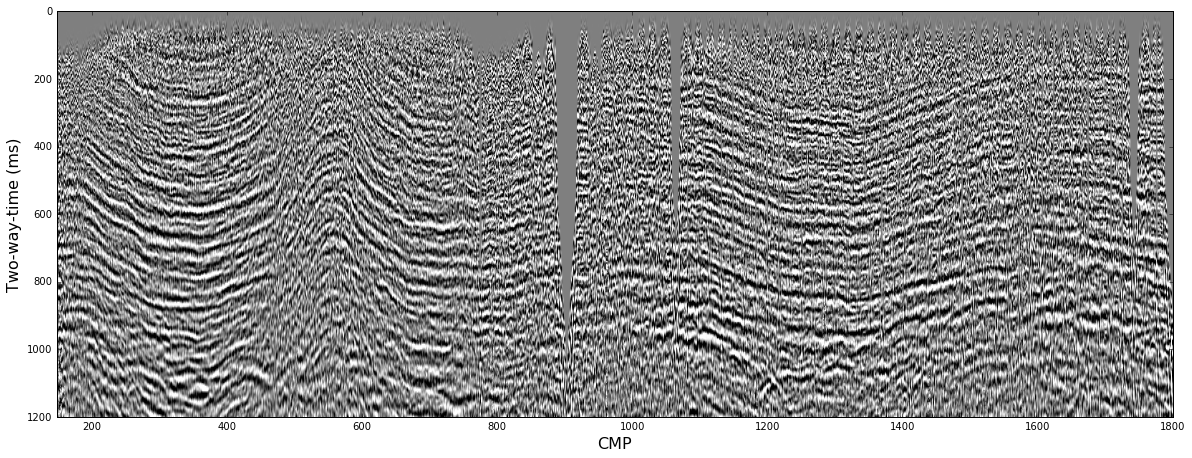

In [24]:
# Where is the ground level surface on this seismic data?

f = plt.figure(figsize=(20,20))
ax = f.add_subplot(111)
ax.imshow(data.T[:300,:], cmap="gray_r", aspect=0.5, clim=[-1000,1000],
           extent = [np.amin(cmp), np.amax(cmp),1200,0])
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel('CMP', fontsize=16)
ax.set_ylabel('Two-way-time (ms)', fontsize=16)
f.savefig('where_is_ground.png', dpi=200)

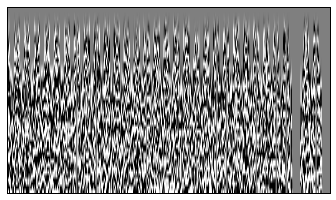

In [25]:
# Zoom in
f = plt.figure(figsize=(20/3,20/6))
ax = f.add_subplot(111)
ax.imshow(data.T[:50,1040:], cmap="gray_r", aspect=0.5*3, clim=[-100,100],
          extent = [1040, 1560, 200,0])
ax.set_xticks([])
ax.set_yticks([])
f.savefig('where_is_ground_zoom.png')

### Plot the elevation profile relative to the seismic reference datum (SRD)

In [26]:
from scipy import interpolate
cmp_new = np.arange(first_CMP, last_CMP+1, 1.0)
fg = interpolate.interp1d(cmp, z/3.2808)  # feet to metres
fd = interpolate.interp1d(x_d, z_d/3.2808)  # feet to metres
z_new = fg(cmp_new)  # use interpolation function returned by `interp1d`
d_new = fd(cmp_new)

In [27]:
SRD = d_new 

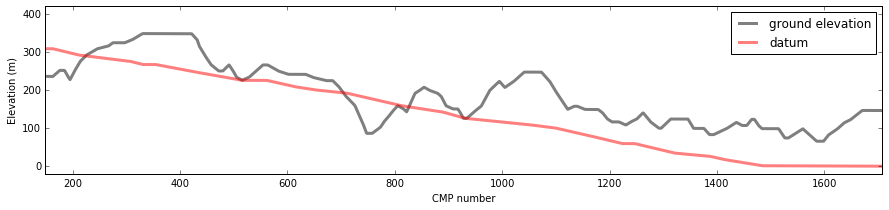

In [28]:
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(111)

# plot ground level

#ax.plot(cmp, z)
ax.plot(cmp_new, z_new, 'k', lw=3, alpha=0.5, label='ground elevation')

# plot SRD
ax.plot(cmp_new, SRD,'r', lw=3, alpha=0.5, label='datum')

# prettying the plot
ax.invert_xaxis()
ax.set_xlabel('CMP number')
ax.set_ylabel('Elevation (m)')

ax.set_ylim(-20,420)
ax.set_xlim(first_CMP, last_CMP)
ax.legend()
fig.savefig('ground_level_depth_structure.png')

Oh god, we've got a variable datum...That's gross. 

# Calculate the ground level travel-time surface

In [29]:
rep_vel = 10000.0 / 3.2808  # according to the JPG of the seismic line, feet to metres
ground_time = 2000*((SRD-z_new) / rep_vel )

Ground level in time domain

148.0 1800.0


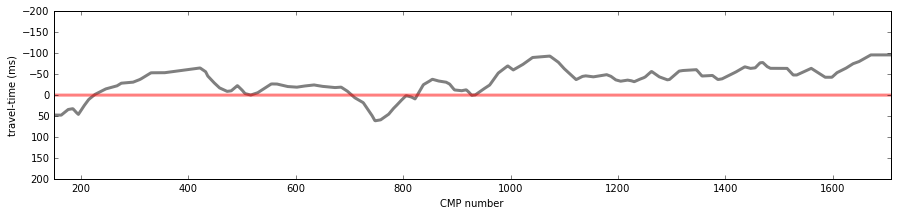

In [30]:
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(111)
# plot ground level
ax.plot(cmp_new, ground_time, 'k', lw=3, alpha=0.5)
# plot SRD
ax.plot(cmp_new,0*np.ones(len(cmp_new)),'r', lw=3, alpha=0.5)
# prettying the plot
ax.invert_xaxis()
ax.set_xlabel('CMP number')
ax.set_ylabel('travel-time (ms)')
ax.set_ylim(200,-200)
ax.set_xlim(first_CMP, last_CMP)
fig.savefig('ground_level_time_structure.png')
print(np.amin(cmp), np.amax(cmp))

# Plot the ground-level on the seismic data

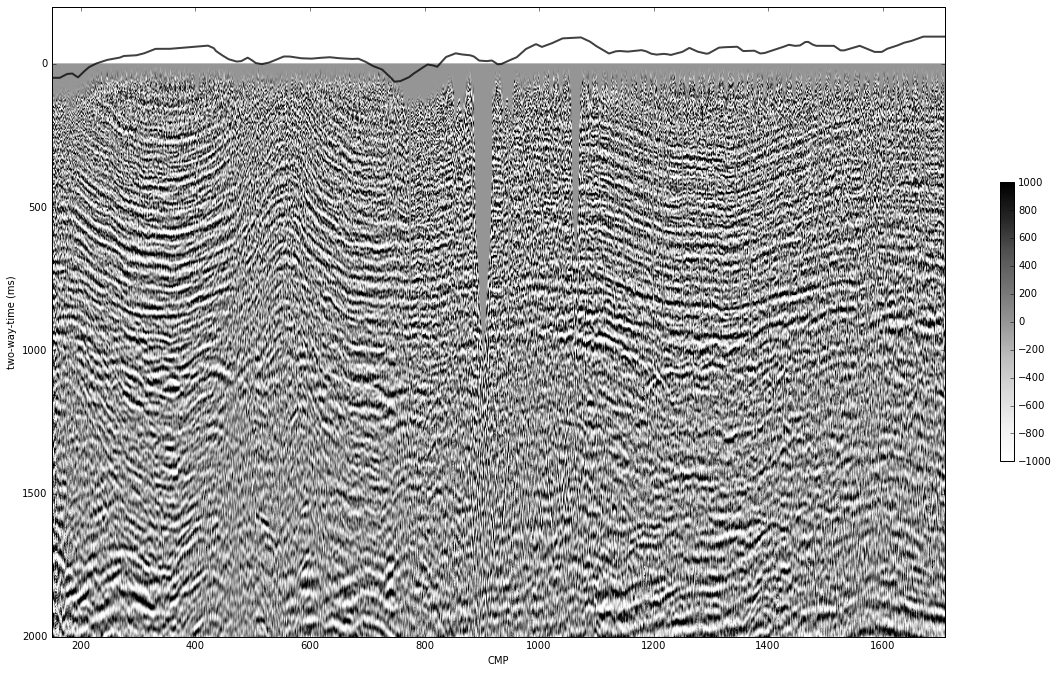

In [31]:
n = 1
maxsamp = 1500
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
 
# plot ground level
ax.plot(cmp_new, ground_time, 'k', lw=2, alpha=0.75)

if False:  # option
    for i in range(4):
        ax.plot(cmp_new, ground_time + 30*(i+1), 'k', lw=2, alpha=0.25)
    
im = ax.imshow(data.T[:maxsamp,::-1], cmap="Greys", aspect=0.5, clim=(-1e3,1e3),
               extent = [np.amax(cmp), np.amin(cmp),maxsamp*dt*1000,0])

ax.set_xlim(np.amin(cmp_new),  np.amax(cmp_new))
ax.set_ylim(2000, np.amin(-200))

ax.set_ylabel('two-way-time (ms)')
ax.set_xlabel('CMP')

# Add a colorbar
fig.colorbar(im, ax=ax, shrink=0.25)

## Burn the ground-level into the data


In [121]:
from bruges.filters import ricker
from scipy.signal import convolve

In [122]:
def make_synth(w, ground_time, pad = 200):
    n_traces, n_samples = data.shape
    synth = np.zeros((n_samples+len(w)-1+pad, n_traces))
    w = w / max(w)   # normalize
    for k in range(n_traces):
        spike = np.zeros(n_samples+pad)
        spike[int(ground_time[k]/(1000*dt)+pad)] = 1
        synth[:,k] = convolve(spike, w)
    synth = synth[ np.ceil(len(w))/2 : -np.ceil(len(w))/2 + 1, : ]
    return np.transpose(synth)

In [215]:
duration = 0.256
dt = tr.header.sample_interval_in_ms_for_this_trace / 1e6
f = 25.0  # dominant frequency in Hz.
w = ricker(duration, dt, f)

In [216]:
ground = make_synth(w, ground_time)

/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [217]:
burn_val = np.percentile(data,99)
n_traces, n_samples = data.shape
pad = 200
data_pad = np.zeros((ntraces, pad))
datumed_data = np.hstack([data_pad, data])

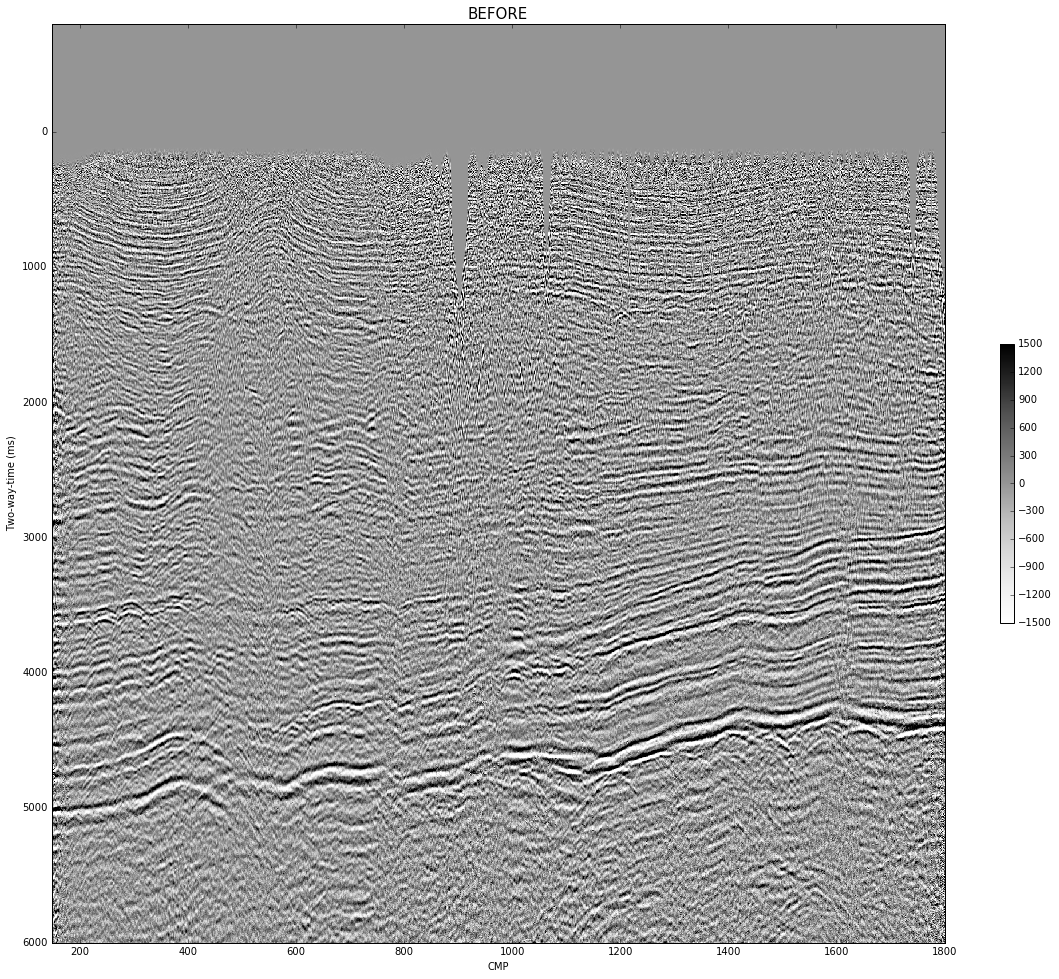

In [218]:
maxt = 1500
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(datumed_data)[:int(maxt),:], cmap="Greys", aspect=0.25, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp),maxt*dt*1000,-800], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
ax.set_ylabel('Two-way-time (ms)')
ax.set_xlabel('CMP')
ax.set_title('BEFORE',  size=15)

#ax.set_ylim(2000, np.amin(-200))

# Add a colorbar
fig.colorbar(im, ax=ax, shrink=0.25)

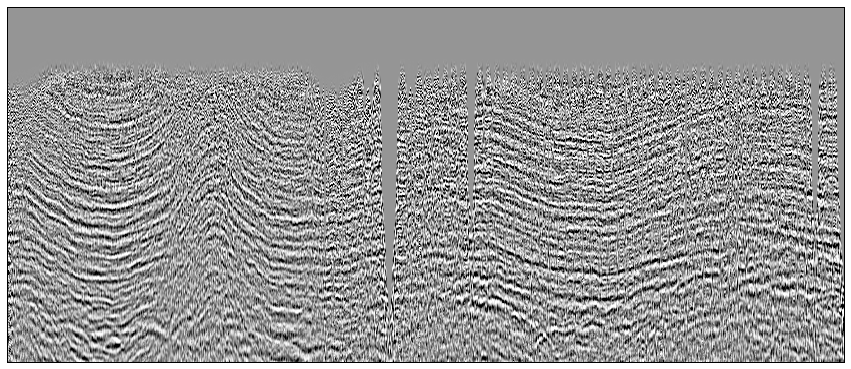

In [234]:
maxt = 300
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(datumed_data)[:int(maxt)+pad,:], cmap="Greys", aspect=0.5, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp),maxt*dt*1000,-pad*dt*1000], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
#ax.set_ylabel('Two-way-time (ms)')
#ax.set_xlabel('CMP')
#ax.set_title('BEFORE',  size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(1200,-200)

# Add a colorbar
#fig.colorbar(im, ax=ax, shrink=0.25)

fig.savefig('where_da_ground_at.png')

In [220]:
burned_seismic = burn_val*ground + datumed_data

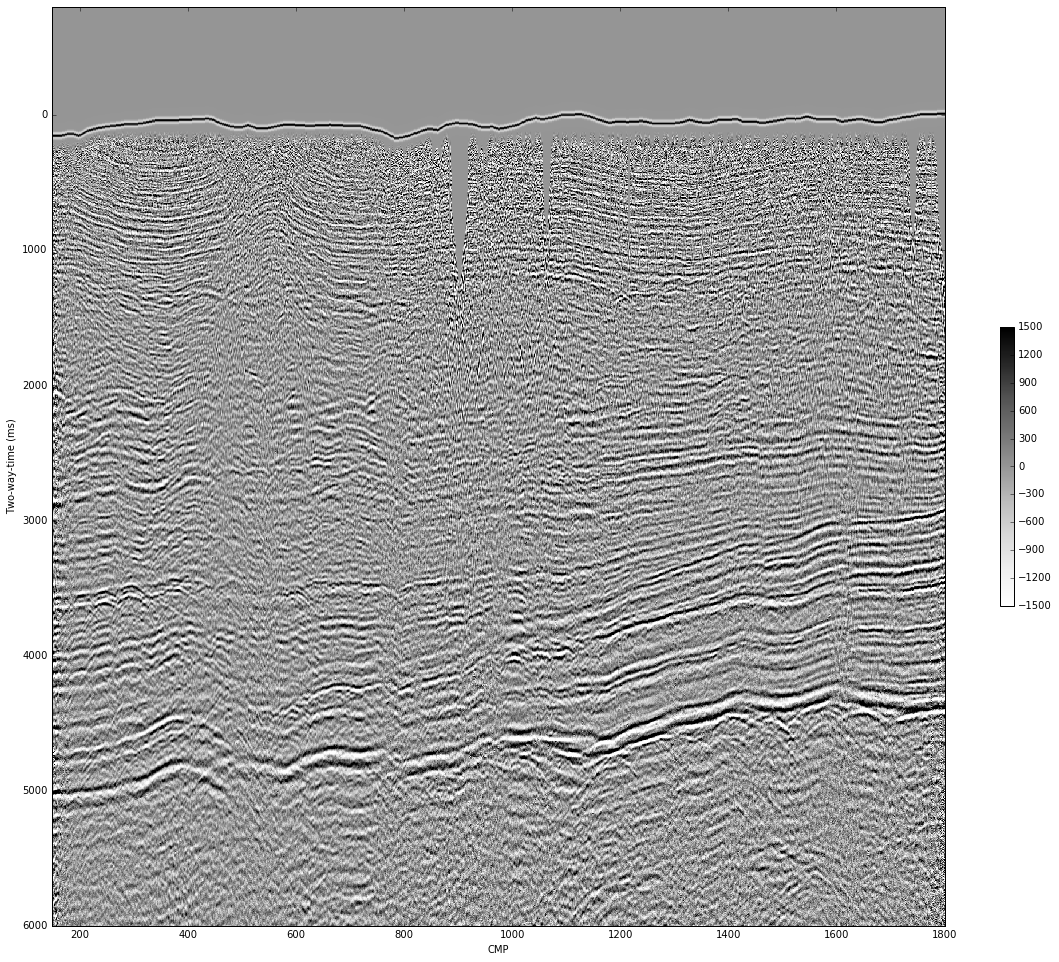

In [238]:
maxt = 1500
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(burned_seismic)[:int(maxt),:], cmap="Greys", aspect=0.25, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp),maxt*dt*1000,-800], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
ax.set_ylabel('Two-way-time (ms)')
ax.set_xlabel('CMP')
#ax.set_title('AFTER',  size=15)
#ax.set_ylim(2000, np.amin(-200))

# Add a colorbar
fig.colorbar(im, ax=ax, shrink=0.25)
fig.savefig('full_section_earth_surface_included.png')

## Zoomed in figure

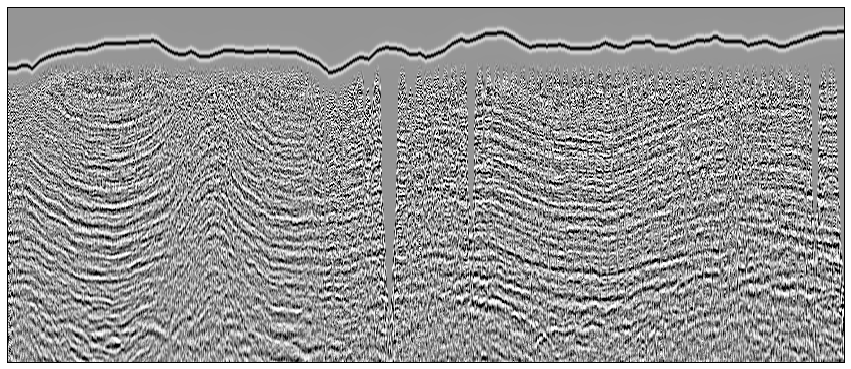

In [235]:
maxt = 300
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(burned_seismic)[:int(maxt)+pad,:], cmap="Greys", aspect=0.5, clim=(-1.5e3,1.5e3),
          extent = [np.amin(cmp), np.amax(cmp),maxt*dt*1000,-800], interpolation='nearest')
ax.set_xlim(np.amin(cmp),  np.amax(cmp))
#ax.set_ylabel('Two-way-time (ms)')
#ax.set_xlabel('CMP')
#ax.set_title('AFTER',  size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(1200,-200)

fig.savefig('here_da_ground_at.png')